In [120]:
from Bio.Align.Applications import ClustalOmegaCommandline
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from tcrdist.repertoire import TCRrep
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from polyleven import levenshtein
from collections import Counter
from itertools import product
import logomaker as lm
from Bio import SeqIO
import networkx as nx
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os 

### Import SARS-CoV-2-associated 
#### Clonotypes obtained by Wilcoxon test & SARS-CoV-2 enriched clonotypes (Thomas)

In [476]:
#feature_search/wilcox_test/WILCOX_TEST_RESULTS/FREQ/Adaptive_FMBA_top_public_2000AA/Adaptive_KECK_FMBA_PRECOVID_public.tsv
associated_clones_wilcox=pd.read_csv("../feature_search/wilcox_test/WILCOX_TEST_RESULTS/FREQ/Adaptive_FMBA_top_public_2000AA/Adaptive_KECK_FMBA_PRECOVID_public.tsv", sep = '\t', index_col=0)
associated_clones_wilcox=list(associated_clones_wilcox.feature)
associated_clones_wilcox=[x for x in  list(associated_clones_wilcox) if ('_' or '*' or '~')  not in str(x)]
associated_clones_wilcox=[x for x in list(associated_clones_wilcox) if  len(x)>=9 and len(x)<=17]
print("Size:", len(associated_clones_wilcox))

Size: 3809


In [112]:
#feature_search/Thomas/SI_table2.tsv
associated_clones_thomas=pd.read_csv("../feature_search/Thomas/SI_table2.tsv", sep = '\t')
print("Number of tcrdist120 clusters:",max(associated_clones_thomas["tcrdist120_cluster_id"]))
associated_clones_thomas=list(associated_clones_thomas.cdr3b)
print("Size:", len(associated_clones_thomas))
associated_clones_thomas=associated_clones_thomas[:1000]

Number of tcrdist120 clusters: 513
Size: 1248


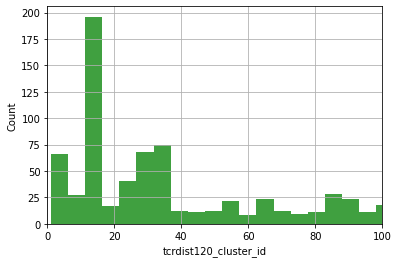

In [18]:
n, bins, patches = plt.hist(associated_clones_thomas["tcrdist120_cluster_id"], 100, density=False, facecolor='g', alpha=0.75)
plt.xlabel('tcrdist120_cluster_id')
plt.ylabel('Count')
plt.grid(True)
plt.xlim(0, 100)
plt.show()

In [68]:
#feature_search/Thomas/SI_table3.tsv
associated_clones_thomas_depl=pd.read_csv("../feature_search/Thomas/SI_table3.tsv", sep = '\t')
#print("Number of tcrdist120 clusters:",max(associated_clones_thomas["tcrdist120_cluster_id"]))
associated_clones_thomas_depl=list(associated_clones_thomas_depl.cdr3b)
print("Size:", len(associated_clones_thomas_depl))
associated_clones_thomas_depl=associated_clones_thomas_depl[:500]

Size: 594


### Function definition

### DBSCAN

In [3]:
def DBSCAN_Cl(eps, min_samples, distance_matrix):
    db=DBSCAN(eps=eps, min_samples=min_samples).fit(distance_matrix)
    cluster_labels=db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_=len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_=list(cluster_labels).count(-1)
    print('n_clusters_:', n_clusters_)
    # get indexes of outliers
    outliers=np.where(cluster_labels==-1)[0] 
    #plot the results
    plt.scatter(D_embedded[outliers,0], D_embedded[outliers,1], s=50, c='grey', marker='o')

### Blosum

In [363]:
#-----import BLOSUM62----
from Bio.SubsMat import MatrixInfo as matlist
from itertools import compress
from Bio import pairwise2
from Bio.Seq import Seq

matrix = matlist.blosum62

#-----reverse BLOSUM62 mismatches and add to matrix
def Reverse(tuples):
    new_tup = tuples[::-1]
    return new_tup

reverse_matrix=[Reverse(aa) for aa in matrix.keys()]
reverse_matrix=dict(zip(reverse_matrix, matrix.values()))
blosum={**matrix, **reverse_matrix}

#-----calculate the penalty-----
def take_dist(mismatch, matrix=blosum):
    gap_penalty=4
    try:
        score = matrix[mismatch]
        dist=min(4, 4-score)
        return dist
    except:
        return gap_penalty


def blosum_penalty(clone1, clone2, matrix=blosum):
    mismatch=[c1 != c2 for c1, c2 in zip(clone1, clone2)]
    mismatch_clone1=compress(clone1, mismatch)
    mismatch_clone2=compress(clone2, mismatch)
    amino_acids=list(zip(mismatch_clone1, mismatch_clone2))
    penalty=sum(take_dist(aa) for aa in amino_acids)
    return penalty
def BLOSUM_match_gap_penalty(clone1, clone2, matrix=blosum):
    if len(clone1)==len(clone2):
        dist=blosum_penalty(clone1, clone2)
    else:
        #------pairwise alignment------
        alignments = pairwise2.align.globalmx(seq1, seq2, 2, -1)
        clone1_alg=list(alignments[0])[0]
        clone2_alg=list(alignments[0])[1]
        dist=blosum_penalty(clone1_alg, clone2_alg)
    return dist     

### Logo from aligment

In [ ]:
#Show the Logo of each cluster
def Convert_faa(cluster_seq):
        with open('Split_FASTA_Files/Cluster%i.tab' %index_cluster,"w") as tab_file:
            for i in cluster_seq:
                tab_file.write(f"{'TRB'}\t{i}" + "\n")
        records = SeqIO.parse("Split_FASTA_Files/Cluster%i.tab" %index_cluster, "tab")
        count = SeqIO.write(records, "Split_FASTA_Files/Cluster%i.fasta" %index_cluster, "fasta")
        os.remove("Split_FASTA_Files/Cluster%i.tab" %index_cluster)
     

for index_cluster in range(n_clusters_):
        cluster=np.where(cluster_labels==index_cluster)[0]
        cluster_seq=[analyzed_clones[i] for i in cluster]
        Convert_faa(cluster_seq)
        
        
# Multiple sequence alignment by Clustal Omega
def ClustalO(index_cluster):
    in_file = 'Split_FASTA_Files/Cluster%d.fasta' % index_cluster
    out_file = 'Aligned_FASTA_Files/Cluster%d_Aligned.fasta' % index_cluster
    cline = ClustalOmegaCommandline(infile=in_file,
                                    outfile=out_file,
                                    verbose=True,
                                    auto=True)
    cline()
    os.remove("Split_FASTA_Files/Cluster%i.fasta" %index_cluster)


Parallel(n_jobs=os.cpu_count())(delayed(ClustalO)(index_cluster) for index_cluster in range(n_clusters_))

def Make_Logo(dir='Split_FASTA_Files/'):
    FASTA_Files=[i for i in os.listdir(dir) if i.endswith("fasta")]
    for i in range(len(FASTA_Files)):
        with open(f'{dir}{FASTA_Files[i]}') as fp:
            lines = fp.readlines()  
            seqs = [seq.strip().upper() for seq in lines if ('#' not in seq) and ('>') not in seq]
            ww_counts_df = lm.alignment_to_matrix(sequences=seqs, to_type='counts', characters_to_ignore='.-X')
            crp_logo=lm.Logo(ww_counts_df, color_scheme='NajafabadiEtAl2017')
            os.remove(f'{dir}{FASTA_Files[i]}') 
            
            
Make_Logo(dir='Aligned_FASTA_Files/')

def Make_Logo_one_out(dir='Split_FASTA_Files/'):
    FASTA_Files=[i for i in os.listdir(dir) if i.endswith("fasta")]
    n=0
    for i in range(len(FASTA_Files)):
        with open(f'{dir}{FASTA_Files[i]}') as fp:
            lines = fp.readlines()  
            seqs = [seq.strip().upper() for seq in lines if ('#' not in seq) and ('>') not in seq]
            ww_counts_df = lm.alignment_to_matrix(sequences=seqs, to_type='counts', characters_to_ignore='.-X')
            ax = plt.subplot2grid((15,6),(n,2),colspan = 2)
            n+=2
            crp_logo=lm.Logo(ww_counts_df, color_scheme='NajafabadiEtAl2017', ax=ax, show_spines=False)
            os.remove(f'{dir}{FASTA_Files[i]}')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('Cluster %i' %i, loc='left')

### Logo from clones of the same length

In [ ]:
n_clusters_seq=[]
for index_cluster in range(n_clusters_):
        cluster=np.where(cluster_labels==index_cluster)[0]
        cluster_seq=[analyzed_clones[i] for i in cluster]
        n_clusters_seq.append(cluster_seq)

#Divide clones into subsets based on their length and take the the most frequent one's
def divideClonesByLenght(clones): 
    dct={}   
    for clone in clones: 
        if len(clone) not in dct: 
            dct[len(clone)]=[clone] 
        elif len(clone) in dct: 
            dct[len(clone)]+=[clone]
    lenght_split_sorted=dict(sorted(list(dct.items()), 
    key=lambda item: len(item[1]), reverse=True))
    Cluster=lenght_split_sorted[next(iter(lenght_split_sorted))]
    return Cluster 

cluster_seqs=list(map(divideClonesByLenght, n_clusters_seq))

def Convert_faa(cluster_seq):
    for index_cluster in range(n_clusters_):
        cluster_seq=cluster_seqs[index_cluster]
        with open('Split_FASTA_Files/Cluster%i.tab' %index_cluster,"w") as tab_file:
            for i in cluster_seq:
                tab_file.write(f"{'TRB'}\t{i}" + "\n")
        records = SeqIO.parse("Split_FASTA_Files/Cluster%i.tab" %index_cluster, "tab")
        count = SeqIO.write(records, "Split_FASTA_Files/Cluster%i.fasta" %index_cluster, "fasta")
#        os.remove("Split_FASTA_Files/Cluster%i.tab" %index_cluster)
        
for cluster_seq in  cluster_seqs:
    Convert_faa(cluster_seq)
    
def Make_Logo(dir='Split_FASTA_Files/'):
    FASTA_Files=[i for i in os.listdir(dir) if i.endswith("fasta")]
    for i in range(len(FASTA_Files)):
        with open(f'{dir}{FASTA_Files[i]}') as fp:
            lines = fp.readlines()  
            seqs = [seq.strip().upper() for seq in lines if ('#' not in seq) and ('>') not in seq]
            ww_counts_df = lm.alignment_to_matrix(sequences=seqs, to_type='counts', characters_to_ignore='.-X')
            crp_logo=lm.Logo(ww_counts_df, color_scheme='NajafabadiEtAl2017')
            os.remove(f'{dir}{FASTA_Files[i]}') 
            
Make_Logo()

def Make_Logo_one_out(dir='Split_FASTA_Files/'):
    FASTA_Files=[i for i in os.listdir(dir) if i.endswith("fasta")]
    n=0
    for i in range(len(FASTA_Files)):
        with open(f'{dir}{FASTA_Files[i]}') as fp:
            lines = fp.readlines()  
            seqs = [seq.strip().upper() for seq in lines if ('#' not in seq) and ('>') not in seq]
            ww_counts_df = lm.alignment_to_matrix(sequences=seqs, to_type='counts', characters_to_ignore='.-X')
            ax = plt.subplot2grid((15,6),(n,2),colspan = 2)
            n+=2
            crp_logo=lm.Logo(ww_counts_df, color_scheme='NajafabadiEtAl2017', ax=ax, show_spines=False)
            os.remove(f'{dir}{FASTA_Files[i]}')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('Cluster %i' %i, loc='left')

### I.Unweighted  network
### I.1.Levenshtein distance


In [29]:
#Levenshtein distance
def leven(Z):
    X,Y = iter(Z)
    scr = levenshtein(X, Y)
    return scr

In [67]:
#Get coordinates by values
def get_coordinates(array, coordinat_array, values):
    coordinates=np.array([])
    for V in values:
        for c, v in zip(coordinat_array, array):
            if V==v:
                coordinates=np.append(coordinates, c)
                break 
    coordinates.shape=(len(values), 2)
    return coordinates            

In [31]:
def expand(x, y, gap=1e-4):
    add = np.tile([0, gap, np.nan], len(x))
    x1 = np.repeat(x, 3) + add
    y1 = np.repeat(y, 3) + add
    return x1, y1

In [32]:
palette=sns.color_palette("Paired", 12)

In [113]:
#Make paiwize distance matrix
analyzed_clones=list(set([*associated_clones_wilcox, *associated_clones_thomas]))

comb = list(product(analyzed_clones, analyzed_clones))
print("lenght of array:", len(comb))
lev = list(map(leven, comb))
print('unique values:', set(lev))
mm = np.array(lev)
mm.shape = (len(analyzed_clones), len(analyzed_clones))
distance_matrix_leven=pd.DataFrame(np.array(mm), index=analyzed_clones, columns=analyzed_clones)

lenght of array: 2673225
unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}


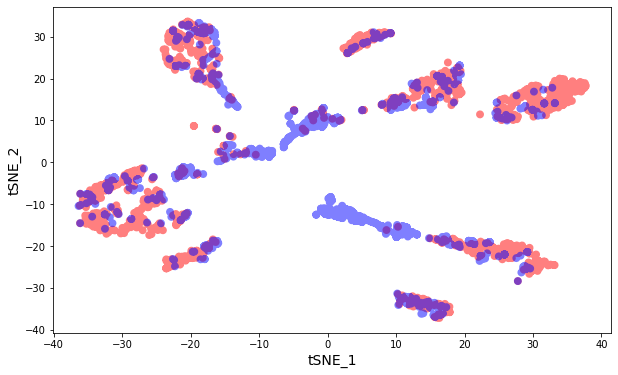

In [55]:
D=pairwise_distances(distance_matrix_leven)
D_embedded=TSNE(n_components=2, perplexity=60).fit_transform(D)

plt.rcParams['lines.solid_capstyle'] = 'round'
plt.rcParams['figure.figsize'] = [10, 6]

wilcox_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_wilcox)
thomas_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_thomas)
plt.plot(*expand(wilcox_data[:,0], wilcox_data[:,1]), lw=8, alpha=0.5, c='red')
plt.plot(*expand(thomas_data[:,0], thomas_data[:,1]), lw=8, alpha=0.5, c='blue')
plt.xlabel('tSNE_1', fontsize=14)
plt.ylabel('tSNE_2', fontsize=14)
plt.show()

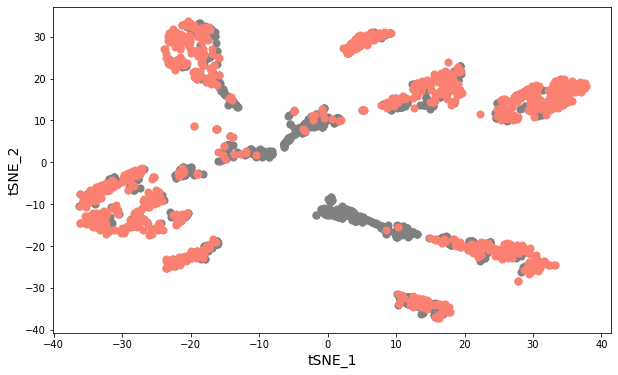

In [56]:
#AB - red
plt.rcParams['figure.figsize'] = [10, 6]

wilcox_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_wilcox)
thomas_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_thomas)
plt.scatter(thomas_data[:,0], thomas_data[:,1], s=50, c='grey', marker='o')
plt.scatter(wilcox_data[:,0], wilcox_data[:,1], s=50, c='salmon', marker='o')
plt.xlabel('tSNE_1', fontsize=14)
plt.ylabel('tSNE_2', fontsize=14)
plt.show()

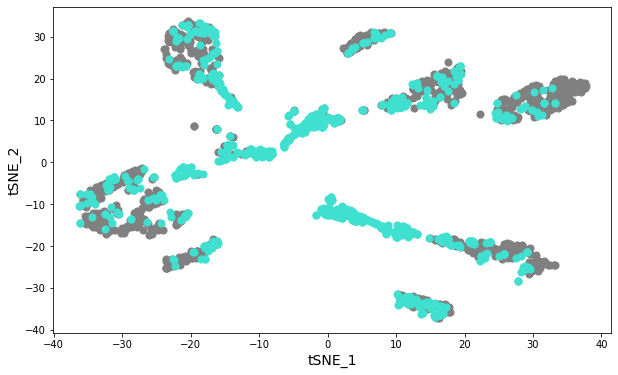

In [57]:
#FMBA - blue
plt.rcParams['figure.figsize'] = [10, 6]

wilcox_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_wilcox)
thomas_data=get_coordinates(analyzed_clones, D_embedded, associated_clones_thomas)
plt.scatter(wilcox_data[:,0], wilcox_data[:,1], s=50, c='grey', marker='o')
plt.scatter(thomas_data[:,0], thomas_data[:,1], s=50, c='Turquoise', marker='o')
plt.xlabel('tSNE_1', fontsize=14)
plt.ylabel('tSNE_2', fontsize=14)
plt.show()

#### Edges connect vertices with < 1 leven dist units

In [136]:
def Edges_treshold(value, treshold=1):
    if value<=treshold:
        value=1
    else: 
        value=0
    return value    
    
unweight_distance_matrix_leven=distance_matrix_leven.applymap(Edges_treshold)

In [213]:
wilcox_index=set([analyzed_clones.index(clone) for clone in associated_clones_wilcox])&set(G.nodes)
thomas_index=set([analyzed_clones.index(clone) for clone in associated_clones_thomas])&set(G.nodes)   
wilcox_colored=dict((i, 'slateblue') for i in wilcox_index)
thomas_colored=dict((i, 'palegreen') for i in thomas_index)
color_map=list(pd.Series({**wilcox_colored, **thomas_colored}).sort_index(ascending=True).values)

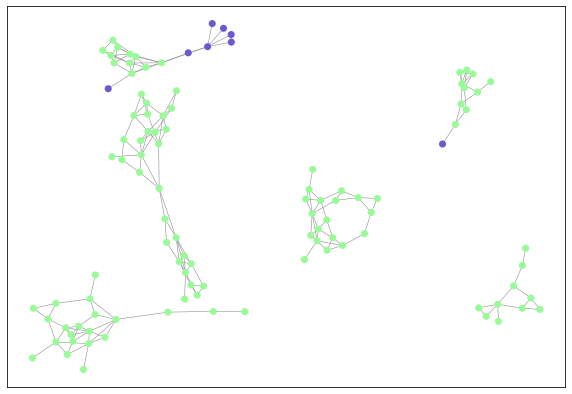

In [331]:
G=nx.Graph(unweight_distance_matrix_leven.values)
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))
Graph_nodes=[n for n, d in G.degree]
connected_component_size=pd.Series(data=[len(nx.node_connected_component(G, node)) for node in Graph_nodes], index=Graph_nodes)
connected_component_ejection=connected_component_size.sort_values(ascending=False).where(connected_component_size < 10).dropna()
G.remove_nodes_from(list(connected_component_ejection.index))
pos = nx.spring_layout(G)
#pos = nx.circular_layout(G)
plt.figure(10,figsize=(10,7)) 
#d = dict(G.degree)
nx.draw_networkx_nodes(G,pos, node_color=color_map, node_size=50, linewidths=0, edgecolors='black')
nx.draw_networkx_edges(G, pos, width=0.5, edge_color='gray')
plt.show()

In [404]:
#-----find unique connected components----
connected_component=[nx.node_connected_component(G, node) for node in G.nodes]
connected_component_sort=[]
for nodes in connected_component:
    connected_component_sort.append(sorted(nodes))
unique_connected_component=[]
for nodes in connected_component:
    if nodes not in unique_connected_component:
        unique_connected_component.append(nodes)
        


### I.2 Blosum62
### dist(a,a)=0; dist(a,b) = min(4, 4-BLOSUM62(a,b)); gap penalty=4; edges_treshold=7

In [365]:
#-----import BLOSUM62----
from Bio.SubsMat import MatrixInfo as matlist
from itertools import compress
from Bio import pairwise2
from Bio.Seq import Seq

matrix = matlist.blosum62

#-----reverse BLOSUM62 mismatches and add to matrix
def Reverse(tuples):
    new_tup = tuples[::-1]
    return new_tup

reverse_matrix=[Reverse(aa) for aa in matrix.keys()]
reverse_matrix=dict(zip(reverse_matrix, matrix.values()))
blosum={**matrix, **reverse_matrix}

#-----calculate the penalty-----
def take_dist(mismatch, matrix=blosum):
    gap_penalty=4
    try:
        score = matrix[mismatch]
        dist=min(4, 4-score)
        return dist
    except:
        return gap_penalty


def blosum_penalty(clone1, clone2, matrix=blosum):
    mismatch=[c1 != c2 for c1, c2 in zip(clone1, clone2)]
    mismatch_clone1=compress(clone1, mismatch)
    mismatch_clone2=compress(clone2, mismatch)
    amino_acids=list(zip(mismatch_clone1, mismatch_clone2))
    penalty=sum(take_dist(aa) for aa in amino_acids)
    return penalty

def BLOSUM_match_gap_penalty(clone1, clone2, matrix=blosum):
    if len(clone1)==len(clone2):
        dist=blosum_penalty(clone1, clone2)
    else:
        #------pairwise alignment------
        alignments = pairwise2.align.globalmx(seq1, seq2, 2, -1)
        clone1_alg=list(alignments[0])[0]
        clone2_alg=list(alignments[0])[1]
        dist=blosum_penalty(clone1_alg, clone2_alg)
    return dist 

#blosum distance
def blosum(Z):
    X,Y = iter(Z)
    scr = BLOSUM_match_gap_penalty(X, Y)
    return scr

In [461]:
#Make paiwize distance matrix
analyzed_clones=list(set(associated_clones_thomas))

comb = list(product(analyzed_clones, analyzed_clones))
print("lenght of array:", len(comb))
bls = list(map(blosum, comb))
print('unique values:', set(bls))
mm = np.array(bls)
mm.shape = (len(analyzed_clones), len(analyzed_clones))
distance_matrix_bls=pd.DataFrame(np.array(mm), index=analyzed_clones, columns=analyzed_clones)


lenght of array: 407044
unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55}


In [471]:
def Edges_treshold(value, treshold=7):
    if value<=treshold:
        value=1
    else: 
        value=0
    return value   

In [472]:
unweight_distance_matrix_bls=distance_matrix_bls.applymap(Edges_treshold)

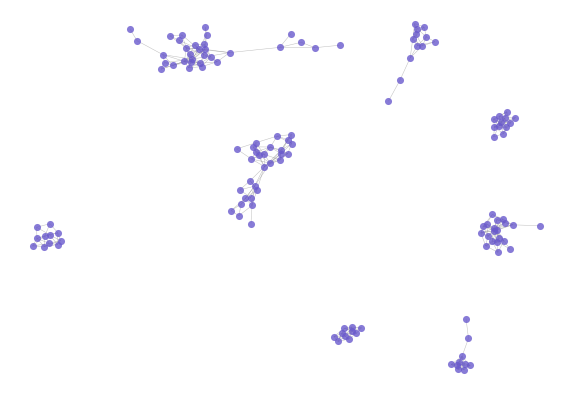

In [473]:
G=nx.Graph(unweight_distance_matrix_bls.values)
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))
Graph_nodes=[n for n, d in G.degree]
connected_component_size=pd.Series(data=[len(nx.node_connected_component(G, node)) for node in Graph_nodes], index=Graph_nodes)
connected_component_ejection=connected_component_size.sort_values(ascending=False).where(connected_component_size < 10).dropna()
G.remove_nodes_from(list(connected_component_ejection.index))



pos = nx.spring_layout(G)
#pos = nx.circular_layout(G)
plt.figure(10,figsize=(10,7)) 
#d = dict(G.degree)
nx.draw_networkx_nodes(G, pos, node_color="slateblue", node_size=50, alpha=0.8,linewidths=0, edgecolors='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5 ,edge_color='gray')
plt.axis("off")
plt.show()

### I.3 Save file with labels of clusters 

In [474]:
#-----find unique connected components----
connected_component=[nx.node_connected_component(G, node) for node in G.nodes]
connected_component_sort=[]
for nodes in connected_component:
    connected_component_sort.append(sorted(nodes))
unique_connected_component=[]
for nodes in connected_component:
    if nodes not in unique_connected_component:
        unique_connected_component.append(nodes)

In [475]:
df = pd.DataFrame(columns=['clone', "length",'bls_clust_id', 'center'])

for ind in range(len(unique_connected_component)):
    cluster=set([analyzed_clones[i] for i in unique_connected_component[ind]])
    unweight_distance_matrix_bls_cluster=unweight_distance_matrix_bls.loc[(unweight_distance_matrix_bls.index.isin(cluster)),
                                   (unweight_distance_matrix_bls.columns.isin(cluster))]
    G0=nx.Graph(unweight_distance_matrix_bls_cluster.values)
    cluster_l=list(cluster)
    cluster_len=[len(clone) for clone in cluster_l]
    center=nx.center(G0)[0]
    center=cluster_l[center]
    df0=pd.DataFrame(columns=['clone', "length",'bls_clust_id', 'center'])
    df0["clone"]=cluster_l
    df0['length']=cluster_len
    df0['bls_clust_id']=ind
    df0["center"]=center
    df=pd.concat([df, df0])
    
df.to_csv("bls_dist_clusters/clust_thomas.tsv", sep='\t', index=None)    

### II. Weighted network
#### 1 DBSCAN

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

n_clusters_: 7
Cluster 0:441
Cluster 1:566
Cluster 2:108
Cluster 3:140
Cluster 4:197
Cluster 5:208
Cluster 6:44


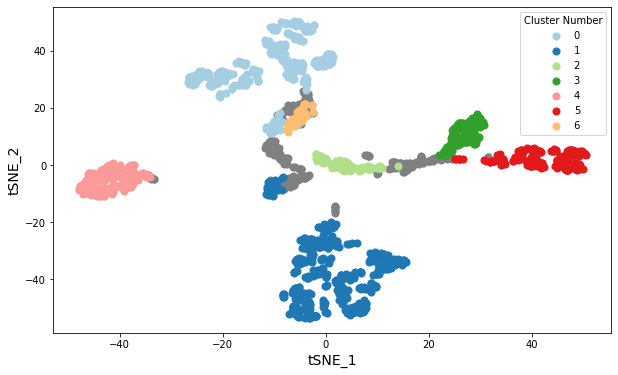

In [22]:
from sklearn.cluster import DBSCAN

plt.rcParams['figure.figsize'] = [10, 6]

def DBSCAN_Cl(eps, min_samples, distance_matrix):
    db=DBSCAN(eps=eps, min_samples=min_samples).fit(distance_matrix)
    cluster_labels=db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_=len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_=list(cluster_labels).count(-1)
    print('n_clusters_:', n_clusters_)
    # get indexes of outliers
    outliers=np.where(cluster_labels==-1)[0] 
    #plot the results
    plt.scatter(D_embedded[outliers,0], D_embedded[outliers,1], s=50, c='grey', marker='o')


    for index_cluster in range(n_clusters_):
        cluster=np.where(cluster_labels==index_cluster)[0]
        print(f'Cluster {index_cluster}:{len(cluster)}')
        plt.scatter(D_embedded[cluster,0], D_embedded[cluster,1], s=50, c=palette[index_cluster], marker='o', label = index_cluster)
    plt.legend(loc='upper right',  numpoints=0.5, title="Cluster Number")
    plt.xlabel('tSNE_1', fontsize=14)
    plt.ylabel('tSNE_2', fontsize=14)

    plt.show()
    return cluster_labels, n_clusters_
cluster_labels, n_clusters_=DBSCAN_Cl(40, 15, distance_matrix_leven)    

### II.2 Logo from clones of the same length

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

n_clusters_: 7
Cluster 0:441
Cluster 1:566
Cluster 2:108
Cluster 3:140
Cluster 4:197
Cluster 5:208
Cluster 6:44


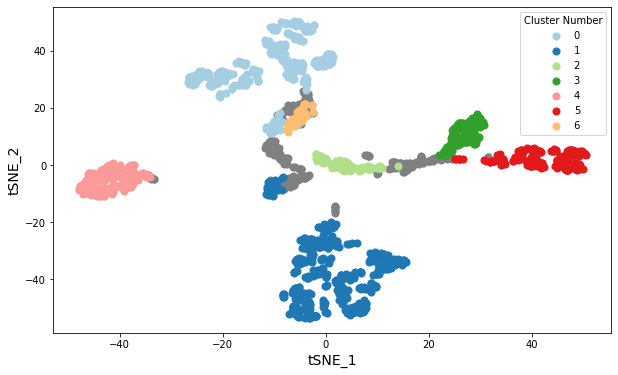

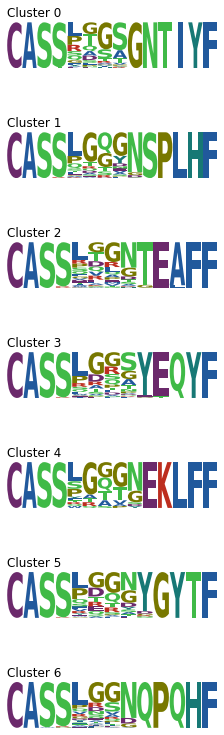

In [28]:
plt.rcParams['figure.figsize'] = [10, 6]

cluster_labels, n_clusters_=DBSCAN_Cl(40, 15, distance_matrix_leven)    

n_clusters_seq=[]
for index_cluster in range(n_clusters_):
        cluster=np.where(cluster_labels==index_cluster)[0]
        cluster_seq=[analyzed_clones[i] for i in cluster]
        n_clusters_seq.append(cluster_seq)

cluster_seqs=list(map(divideClonesByLenght, n_clusters_seq))        

for cluster_seq in cluster_seqs:
    Convert_faa(cluster_seq)
    
plt.rcParams['figure.figsize'] = [12, 15]

Make_Logo_one_out()    

### II.3 Distribution of clone lengths within clusters

In [143]:
path='custers_analize/AB_Fisher_FMBA_Ttest_associated_clones/lenght_analize/leven_dist/'
file_name='DBSCAN_length_spread_eps40.tsv'

analyzed_clones_lenghts=[len(seq) for seq in analyzed_clones]
lenghts_table=pd.DataFrame({"lenght":analyzed_clones_lenghts}, index=analyzed_clones)
lenghts_table['n_cluster']='outliers'

db=DBSCAN(eps=40, min_samples=15).fit(distance_matrix_leven)
cluster_labels=db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_=len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise_=list(cluster_labels).count(-1)
print('n_clusters_:', n_clusters_)

for index_cluster in range(n_clusters_):
    cluster=np.where(cluster_labels==index_cluster)[0]
    cluster_seq=[analyzed_clones[i] for i in cluster]
    lenghts_table.loc[set(cluster_seq), 'n_cluster']=f'{index_cluster}_cluster'
    
lenghts_table.to_csv(f"{path}{file_name}", sep='\t')
    
lenghts_table.to_csv(f"{path}{file_name}", sep='\t')

n_clusters_: 7


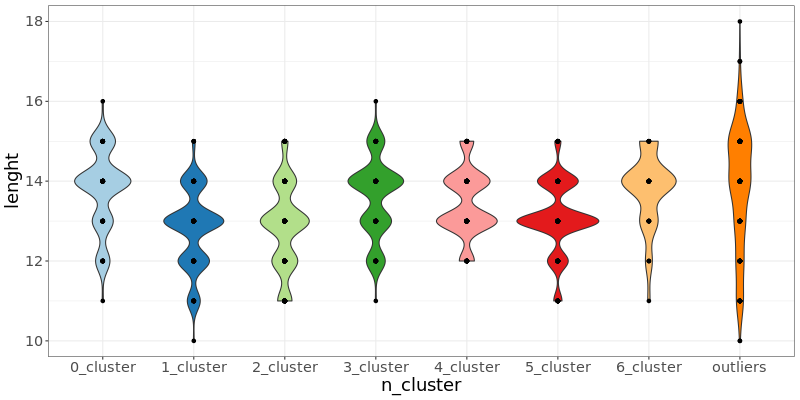

In [149]:
%%R -w 800 -h 400
l=read.csv('custers_analize/AB_Fisher_FMBA_Ttest_associated_clones/lenght_analize/leven_dist/DBSCAN_length_spread_eps40.tsv', sep="\t", header=TRUE)
ggplot(l, aes(x=n_cluster, y=lenght, fill=n_cluster) ) + 
geom_violin() +
geom_point() +
scale_fill_brewer(palette = "Paired")+
theme_bw()+
theme(legend.position = "none") + theme(text=element_text(size=18,  family="Comic Sans MS")) 

### II.4 Save clones from clusters

In [29]:
clusters_seq=[]
for index_cluster in range(n_clusters_):
        cluster=np.where(cluster_labels==index_cluster)[0]
        cluster_seq=[analyzed_clones[i] for i in cluster]
        clusters_seq=[*clusters_seq, *cluster_seq]

In [156]:
clusters_seq='\n'.join(clusters_seq)

myText = open('../../fmba_and_adaptive/fmba_and_adaptive_clusters_leven.tsv','w')
myText.write(clusters_seq)
myText.close()

In [51]:
clusters_seq=[]
for index_cluster in range(n_clusters_):
        cluster=np.where(cluster_labels==index_cluster)[0]
        cluster_seq=[analyzed_clones[i] for i in cluster]
        clusters_seq=[*clusters_seq, *cluster_seq]

    
table_clusters=pd.DataFrame({"CLUSTER": [0]*len(clusters_seq)}, index=clusters_seq)    

for index_cluster in range(n_clusters_):
    cluster=np.where(cluster_labels==index_cluster)[0]
    cluster_seq=[analyzed_clones[i] for i in cluster]
    table_clusters.loc[set(table_clusters.index)&set(cluster_seq), "CLUSTER"]=index_cluster
  

In [54]:
table_clusters.to_csv("CLUSTERS_AB_FMBA.tsv", sep="\t")